In [1]:
import pygame
from pygame import Vector2
from pygame.font import Font
import random
import numpy as np
from configurations import *
from enum import Enum

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
GRID_WIDTH = SCREEN_WIDTH/GRID_SIZE
GRID_HEIGHT = SCREEN_HEIGHT/GRID_SIZE

In [3]:
class ACTIONS:
    LEFT = Vector2(-1, 0)
    RIGHT = Vector2(1, 0)
    UP = Vector2(0, -1)
    DOWN = Vector2(0, 1)

In [4]:
class Object:
    def __init__(self, position=Vector2(0, 0), color=DEFAULT_COLOR, size=Vector2(GRID_SIZE, GRID_SIZE)):
        self._position = position * GRID_SIZE
        self.color = color
        self.size = size

    @property
    def position(self):
        return self._position / GRID_SIZE

    @position.setter
    def position(self, new_position):
        self._position = new_position * GRID_SIZE

    def render(self, screen):
        pygame.draw.rect(screen, self.color, [self._position.x, self._position.y, self.size.x, self.size.y])

In [5]:
class Food(Object):
    def __init__(self, value=1): #Give the value a default value
        super().__init__(color=FOOD_COLOR)
        self.value = value
        self.spawn()

    def spawn(self):
        self.position = Vector2(random.randrange(0, GRID_WIDTH), random.randrange(0, GRID_HEIGHT))

In [6]:
class Snake(Object):
    def __init__(self, speed=10, length=3):
        super().__init__(Vector2(GRID_WIDTH-10, GRID_HEIGHT//2))
        self.speed = speed
        self.score = 0
        self.steps = 0
        self.length = length
        self.body = [Object(Vector2(GRID_WIDTH-10, (GRID_HEIGHT//2)+i+1), SNAKE_COLOR) for i in range(length)]
        self.dir = Vector2(0, 1)

    def danger(self, x=None, y=None):
        x = x if x is not None else self.position.x
        y = y if y is not None else self.position.y

        if x < 0 or x >= SCREEN_WIDTH//GRID_SIZE or y < 0 or y >= SCREEN_HEIGHT//GRID_SIZE:
            return True
        for block in self.body[:-1]:  
            if block.position.x == x and block.position.y == y:
                return True
        return False

    def eat(self, food):
        self.score += food.value
        self.length += 1

    def render(self, screen):
        for block in self.body:            
            block.render(screen)

    def move(self):
        self.position = (self.position + self.dir)
        self.body.append(Object(self.position, SNAKE_COLOR))
        if len(self.body) > self.length:
            self.body.pop(0)
        self.steps += 1


In [7]:
class Player(Snake):
    def __init__(self, speed=10, length=1):
        super().__init__(speed, length)

    def decide(self, env):
        prev_dir = self.dir
        for event in pygame.event.get():
            type = event.type
            if type == pygame.QUIT:
                env.game_close = True
            if type == pygame.KEYDOWN:
                key = event.key
                if event.key == pygame.K_ESCAPE:
                    env.game_over = True
                elif prev_dir.x == 0:
                    if key == pygame.K_LEFT or key == pygame.K_a:
                        self.dir = ACTIONS.LEFT
                    elif key == pygame.K_RIGHT or key == pygame.K_d:
                        self.dir = ACTIONS.RIGHT
                elif prev_dir.y == 0:
                    if key == pygame.K_UP or key == pygame.K_w:
                        self.dir = ACTIONS.UP
                    elif key == pygame.K_DOWN or key == pygame.K_s:
                        self.dir = ACTIONS.DOWN

In [8]:
class Agent(Snake):
    q_table = {}
    epsilon = 1.0
    alpha = 0.01
    gamma = 0.95
    actions = [ACTIONS.LEFT, ACTIONS.RIGHT, ACTIONS.UP, ACTIONS.DOWN]  

    def __init__(self, speed=10, length=3):
        super().__init__(speed, length)

    def decide(self, env):
        state = self.state_representation(env)
        action = self.choose_action(state)
        self.dir = action  
        return action
    def state_representation(self, env):
        food = env.food
        state = []

        state.append(1 if food.position.x < self.position.x else 0)
        state.append(1 if food.position.x > self.position.x else 0)
        state.append(1 if food.position.y < self.position.y else 0)
        state.append(1 if food.position.y > self.position.y else 0)

        state.append(1 if self.danger(self.position.x - 1, self.position.y) else 0)
        state.append(1 if self.danger(self.position.x + 1, self.position.y) else 0)
        state.append(1 if self.danger(self.position.x, self.position.y - 1) else 0)
        state.append(1 if self.danger(self.position.x, self.position.y + 1) else 0)

        return tuple(state)


    def choose_action(self, state):
        if state not in Agent.q_table:
            Agent.q_table[state] = np.zeros(len(Agent.actions))
            
        
        if np.random.uniform(0, 1) < Agent.epsilon:
            return random.choice(Agent.actions)  
        else:
            action_idx = np.argmax(Agent.q_table[state])
            return Agent.actions[action_idx]  

    def update_q_table(self, state, action, reward, next_state):
        if state not in Agent.q_table:
            Agent.q_table[state] = np.zeros(len(Agent.actions))
        if next_state not in Agent.q_table:
            Agent.q_table[next_state] = np.zeros(len(Agent.actions))

        action_index = Agent.actions.index(action)
        best_next_action = np.argmax(Agent.q_table[next_state])
        td_target = reward + Agent.gamma * Agent.q_table[next_state][best_next_action]
        td_delta = td_target - Agent.q_table[state][action_index]
        Agent.q_table[state][action_index] += Agent.alpha * td_delta

    def get_reward(self, env):
        if self.danger():
            return -1  
        if self.position == env.food.position:
            return 10  
        return -0.1    

    def train(self, env):
        state = self.state_representation(env)
        action = self.decide(env)
        next_head = self.position + action

        if self.danger(next_head.x, next_head.y): 
            reward = -1
            self.update_q_table(state, action, reward, state) 
            return 
        
        self.dir = action
        self.move()
        reward = self.get_reward(env)
        next_state = self.state_representation(env)
        self.update_q_table(state, action, reward, next_state)
        Agent.epsilon = max(0.01, Agent.epsilon * 0.999)

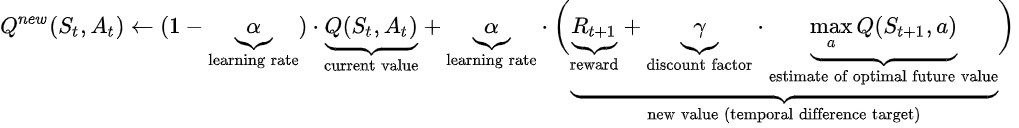

In [9]:
class Game:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        pygame.display.set_caption("Snake Game")
        self.clock = pygame.time.Clock()

        self.snake = Player(15, 3)
        self.food = Food()
        self.font_style = Font("./Fonts/Pixelify_Sans/static/PixelifySans-Regular.ttf", 25)

        self.game_over = False
        self.game_close = False

    def UI(self):
        self.screen.blit(self.font_style.render("Your Score: " + str(self.snake.score), True, (255, 255, 255)), [0, 0])
        self.screen.blit(self.font_style.render("Steps: " + str(self.snake.steps), True, (255, 255, 255)), [0, 50])
        
    def message(self, msg, color):
        mesg = self.font_style.render(msg, True, color)
        self.screen.blit(mesg, [SCREEN_WIDTH / 6, SCREEN_HEIGHT / 3])

    def reset(self):
        self.snake.__init__()
        self.food.spawn()

    def train_agent(self, episodes=700):
        total_score = 0
        n = 0
        for episode in range(episodes):
            self.reset()
            while not self.game_over and self.snake.steps < 500:
                self.snake.train(self)
                if self.snake.danger():
                    self.game_over = True
                if self.snake.position == self.food.position:
                    self.food.spawn()
                    self.snake.length += 1
                    total_score += 1
                self.screen.fill(BACKGROUND_COLOR)
                self.food.render(self.screen)
                self.snake.render(self.screen)
                self.UI()
            n += 1
            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{episodes} completed. Steps: {self.snake.steps}, Average Score: {total_score/n}")
                total_score = 0
                n = 0
        print("Training complete!")
    
    def play(self):
        while not self.game_close:
            while self.game_over:
                if self.snake.__class__.__name__ == "Agent":
                    self.reset()
                else:
                    self.screen.fill((0, 0, 0))
                    self.message("You Lost! Press R-Replay or ESC-Quit", (255, 0, 0))
                    self.UI()
                    pygame.display.update()

                    for event in pygame.event.get():
                        if event.type == pygame.QUIT:
                            self.game_close = True
                        if event.type == pygame.KEYDOWN:
                            if event.key == pygame.K_ESCAPE:
                                self.game_close = True
                            if event.key == pygame.K_r:
                                self.reset()

            self.snake.decide(self)
            self.snake.move()
            
            if self.snake.danger():
                self.game_over = True

            if self.snake.position == self.food.position:
                self.food.spawn()
                self.snake.length += 1

            self.screen.fill(BACKGROUND_COLOR)
            self.food.render(self.screen)
            self.snake.render(self.screen)
            self.UI()

            pygame.display.update()
            self.clock.tick(self.snake.speed)

        pygame.quit()
        quit()

if __name__ == "__main__":
    game = Game()
    print("Starting training...")
    game.train_agent(episodes=600)
    print("Starting interactive gameplay...")
    game.play()

C:\Users\sheha\AppData\Local\Temp\ipykernel_17892\2943624311.py:8: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  self.position = Vector2(random.randrange(0, GRID_WIDTH), random.randrange(0, GRID_HEIGHT))


Starting training...
Starting interactive gameplay...


KeyboardInterrupt: 